In [1]:
%matplotlib inline

import logging
logging.getLogger('tensorflow').disabled = True

import sys
sys.path.append("../../TransportNets")

import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import tensorflow as tf
import tensorflow_probability as tfp

from Models.NVP import NVP
from Probability.Distributions import RotatedBanana
from Probability.MCMC import RTO_MH

tfd = tfp.distributions
tfb = tfp.bijectors

## Train the Normalizing Flow
First, we train the flow to map a double banana distribution to a guassian. The end goal is to perform conditional sampling using MCMC along a part of the distribution where we cross 2 different 'modes'. 

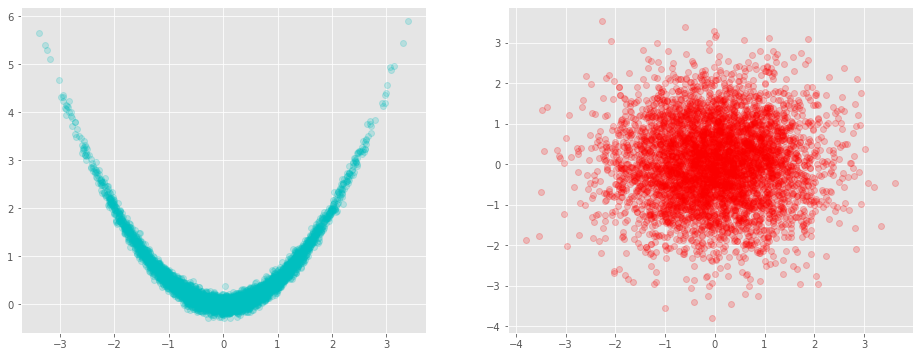

In [2]:
# Distrubtion that we want to learn to map to gaussian 
num_samples = 5000

target = RotatedBanana(num_samples, 0.0)
latent = tf.random.normal([num_samples,2],mean=0.0,stddev=1.0)

# Plot them
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121); ax2 = plt.subplot(122);
ax1.plot(target[:,0], target[:,1], 'co', alpha = .2)
ax2.plot(latent[:,0], latent[:,1], 'ro', alpha = .2)

In [3]:
# Create model object
nvp = NVP(num_layers=2, neuron_list=[500,500])

# Create optimizer and compile nvp with it
opt = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-06)
nvp.compile(opt)

# Perform a forward pass to initialize variables
_ = nvp(latent)

In [4]:
# Define training options
n_epochs = 150
batch_size = 50

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=5000).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
history = nvp.fit(dataset, epochs=n_epochs)  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 2.2228
Epoch 2/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 1.8826
Epoch 3/150
100/100 [==============================] - 1s 6ms/step - Negative Log Likelihood: 1.6132
Epoch 4/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 1.3742
Epoch 5/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 1.1578
Epoch 6/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.9852
Epoch 7/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.8584
Epoch 8/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.7828
Epoch 9/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.7435
Epoch 10/150
100/100 [==============================] - 1s 6ms/step - Negative Log Likeliho

100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.5387
Epoch 82/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.5422
Epoch 83/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.5431
Epoch 84/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.5370
Epoch 85/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.5334
Epoch 86/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.5374
Epoch 87/150
100/100 [==============================] - 1s 8ms/step - Negative Log Likelihood: 0.5396
Epoch 88/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.5387
Epoch 89/150
100/100 [==============================] - 1s 8ms/step - Negative Log Likelihood: 0.5396
Epoch 90/150
100/100 [==============================] - 1s 8ms/step - Negative Log Likelihood: 

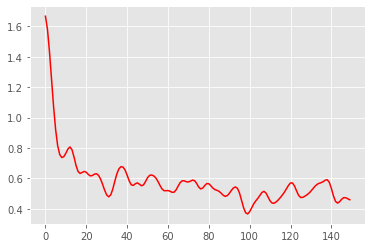

In [5]:
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(history.history['Negative Log Likelihood'], sigma=2)
plt.plot(ysmoothed, color = 'r')

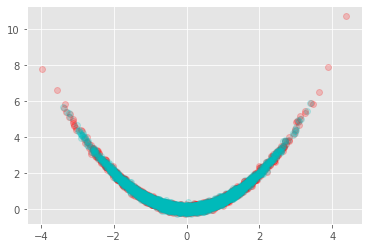

In [6]:
# Plot to make sure it worked
forward_pass = nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
plt.plot(target[:,0], target[:,1], 'co', alpha = .2)

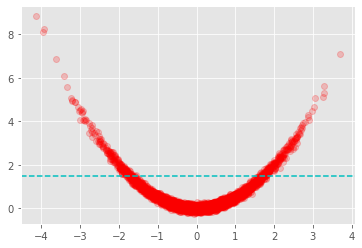

In [7]:
# We want to draw condition samples from about y = 0.0
y_star = 1.5

forward_pass = nvp(tf.random.normal([5000,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
plt.axhline(y=y_star, color='c', linestyle='--')

In [8]:
rto = RTO_MH(nvp, 2, 1, 1000)

ValueError: in user code:

    ../../TransportNets/Probability/MCMC.py:101 H_loss_and_gradient  *
        lambda v: 0.5*tf.norm(self.H(v),axis=-1)**2, v)
    ../../TransportNets/Probability/MCMC.py:97 H  *
        return tf.concat([v,self.G(v)],-1)
    ../../TransportNets/Probability/MCMC.py:94 G  *
        return (self.model(v)[:,(self.n-self.m):]-self.y)@self.S_obs_inv
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:984 binary_op_wrapper
        return func(x, y, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:180 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:2984 matmul
        a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_math_ops.py:5587 mat_mul
        name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:3327 _create_op_internal
        op_def=op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:1817 __init__
        control_input_ops, op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 1 and 6 for '{{node matmul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](sub, matmul/b)' with input shapes: [1,1], [6,6].
